# XGBoost Hyperparameter Tuning

**Description**:\
After getting the Cross-Validation results, the aim on this notebook will be testing the models with the best results and applying the hyper parameters optimization.

**Author**: Elmo Chavez\
**Date**: October 31, 2023

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Sklearn Score metrics
#from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import accuracy_score, classification_report
# Classifier
import xgboost as xgb
# Shappley method
import shap
# print the JS visualization code to the notebook
shap.initjs()
# Hyperparameters tunning method
import optuna
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# EEG Methods
path_eeg_mne = os.path.abspath(os.path.join(os.path.dirname('eeg_mne.py'), '..'))
sys.path.append(path_eeg_mne)
import eeg_mne

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

## Read the Data

Read Training Datasets

In [2]:
path = '../Training Dataset/'
file_psd_feat_all = 'PSD_Features-All_Channels.csv'
file_psd_feat_fp1 = 'PSD_Features-FP1_Channel.csv'

df_psd_features_all = pd.read_csv(path+file_psd_feat_all)
df_psd_features_fp1 = pd.read_csv(path+file_psd_feat_fp1)

print('PSD Features All Channels shape:', df_psd_features_all.shape)
print('PSD Features FP1 Channel shape:', df_psd_features_fp1.shape)

PSD Features All Channels shape: (44, 6274)
PSD Features FP1 Channel shape: (44, 334)


Read Results from Cross-Validation

In [3]:
file_results = 'Results PSD - Cross-Validation.csv'

df_results_psd_cv = pd.read_csv(path+file_results, index_col=0)
df_results_psd_cv = df_results_psd_cv.sort_values(['AUC','accuracy','f1_score'],ascending=False)
df_results_psd_cv.head(10)

,feature_extraction,channels,classifier,cross-validation,feature-selection,accuracy,f1_score,AUC
26,PSD,All,XGBoost,StratifiedShuffleSplit,chi2,0.733333,0.726450,0.750000
68,PSD,Fp1,XGBoost,StratifiedKFold,chi2,0.730556,0.727937,0.735000
64,PSD,Fp1,XGBoost,KFold,mutual_info_classif,0.708333,0.702807,0.728333
37,PSD,All,AdaBoost,KFold,mutual_info_classif,0.705556,0.701111,0.710000
59,PSD,Fp1,Random Forest,StratifiedKFold,chi2,0.702778,0.697013,0.710000
71,PSD,Fp1,XGBoost,StratifiedShuffleSplit,chi2,0.688889,0.683117,0.700000
14,PSD,All,Random Forest,StratifiedKFold,chi2,0.683333,0.671111,0.700000
17,PSD,All,Random Forest,StratifiedShuffleSplit,chi2,0.688889,0.680000,0.695000
41,PSD,All,AdaBoost,StratifiedKFold,chi2,0.680556,0.677143,0.695000
20,PSD,All,XGBoost,KFold,chi2,0.663889,0.651053,0.691667


## Quick Explore of the Data

In [4]:
eeg_mne.Dataset_Features_Summary(df_psd_features_all)
df_psd_features_all.head()

Total Features: 6274
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 19 -> ['F8', 'P3', 'Fp2', 'P4', 'Fp1', 'C4', 'T3', 'F3', 'F7', 'O1', 'T6', 'T4', 'T5', 'Fz', 'F4', 'O2', 'Pz', 'C3', 'Cz']
Frequency Bands: 5 -> ['theta', 'delta', 'alpha', 'beta', 'gamma']
Features: 6 -> ['std dev', 'average power', 'peak to peak', 'relative power', 'total power', 'spectral entropy']


,participant_id,w0_Fp1_delta_total_power,w0_Fp2_delta_total_power,w0_F3_delta_total_power,w0_F4_delta_total_power,w0_C3_delta_total_power,w0_C4_delta_total_power,w0_P3_delta_total_power,w0_P4_delta_total_power,w0_O1_delta_total_power,...,w10_T3_gamma_peak_to_peak,w10_T4_gamma_peak_to_peak,w10_T5_gamma_peak_to_peak,w10_T6_gamma_peak_to_peak,w10_Fz_gamma_peak_to_peak,w10_Cz_gamma_peak_to_peak,w10_Pz_gamma_peak_to_peak,Gender,Age,Group
0,sub-001,1.482606e-10,1.399864e-10,1.315407e-10,1.296565e-10,1.282590e-10,1.303774e-10,1.333272e-10,1.370710e-10,1.435011e-10,...,3.386688e-13,2.955004e-13,5.828301e-13,3.091508e-13,2.907760e-13,2.915964e-13,2.048106e-13,0,57,0
1,sub-002,1.079119e-10,1.114170e-10,1.113520e-10,1.128301e-10,1.113290e-10,1.130439e-10,1.129429e-10,1.143529e-10,1.139642e-10,...,2.484285e-13,2.515664e-13,2.061092e-13,2.073052e-13,1.989391e-13,1.647601e-13,1.809839e-13,0,78,0
2,sub-004,1.405334e-10,1.227932e-10,1.387294e-10,1.335640e-10,1.315632e-10,1.274436e-10,1.349376e-10,1.327209e-10,1.358135e-10,...,4.622522e-13,5.365377e-13,3.226660e-13,3.864883e-13,2.263159e-13,1.842558e-13,2.225526e-13,0,67,0
3,sub-005,1.656372e-10,1.305764e-10,1.400050e-10,1.418274e-10,1.371958e-10,1.362168e-10,1.447223e-10,1.434388e-10,1.424622e-10,...,2.383642e-12,4.735548e-13,4.784333e-13,4.677075e-13,3.885211e-13,2.389231e-13,2.789744e-13,1,70,0
4,sub-006,1.592726e-10,1.492380e-10,1.578813e-10,1.494216e-10,1.517660e-10,1.446006e-10,1.480658e-10,1.489056e-10,1.517877e-10,...,9.004288e-13,3.977423e-13,4.030327e-13,4.308146e-13,3.449713e-13,2.547785e-13,2.279764e-13,0,61,0


In [5]:
eeg_mne.Dataset_Features_Summary(df_psd_features_fp1)
df_psd_features_fp1.head()

Total Features: 334
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 1 -> ['Fp1']
Frequency Bands: 5 -> ['theta', 'delta', 'alpha', 'beta', 'gamma']
Features: 6 -> ['std dev', 'average power', 'peak to peak', 'relative power', 'total power', 'spectral entropy']


,participant_id,w0_Fp1_delta_total_power,w1_Fp1_delta_total_power,w2_Fp1_delta_total_power,w3_Fp1_delta_total_power,w4_Fp1_delta_total_power,w5_Fp1_delta_total_power,w6_Fp1_delta_total_power,w7_Fp1_delta_total_power,w8_Fp1_delta_total_power,...,w4_Fp1_gamma_peak_to_peak,w5_Fp1_gamma_peak_to_peak,w6_Fp1_gamma_peak_to_peak,w7_Fp1_gamma_peak_to_peak,w8_Fp1_gamma_peak_to_peak,w9_Fp1_gamma_peak_to_peak,w10_Fp1_gamma_peak_to_peak,Gender,Age,Group
0,sub-001,1.482606e-10,1.539664e-10,1.640913e-10,1.277807e-10,1.546334e-10,1.602554e-10,1.522455e-10,1.391906e-10,1.629814e-10,...,7.380106e-13,5.186201e-13,5.164246e-13,4.919865e-13,4.522907e-13,4.652932e-13,5.643991e-13,0,57,0
1,sub-002,1.079119e-10,1.032955e-10,1.220342e-10,1.187597e-10,1.227705e-10,1.210614e-10,1.277992e-10,1.234906e-10,1.256641e-10,...,7.699532e-13,3.676913e-13,2.817223e-13,2.394770e-13,3.544304e-13,2.473381e-13,2.063013e-13,0,78,0
2,sub-004,1.405334e-10,1.819675e-10,1.542677e-10,1.718428e-10,1.167535e-10,1.211645e-10,1.382233e-10,1.551854e-10,1.771741e-10,...,8.399157e-13,8.695519e-13,7.697982e-13,8.206731e-13,6.854909e-13,4.246755e-13,4.607840e-13,0,67,0
3,sub-005,1.656372e-10,1.230197e-10,1.331212e-10,1.666786e-10,1.776709e-10,1.571387e-10,1.633155e-10,1.683460e-10,1.507685e-10,...,1.491440e-12,1.000392e-12,7.040914e-13,7.395305e-13,1.422540e-12,2.014033e-12,1.652614e-12,1,70,0
4,sub-006,1.592726e-10,1.497835e-10,1.307667e-10,1.378685e-10,1.364859e-10,1.274019e-10,1.437636e-10,1.490190e-10,1.466645e-10,...,3.440082e-13,3.092531e-13,3.348430e-13,3.375979e-13,3.341492e-13,4.838252e-13,4.263739e-13,0,61,0


**Note**\
For all the score metrics the best model has been the XGBoost.

List to Save Score Results

In [6]:
list_scores = []

# XGBoost Modeling

## All Channels

In [7]:
cols_to_drop = ['participant_id','Group']

In [8]:
X = df_psd_features_all.drop(columns=cols_to_drop).to_numpy()
feature_names = df_psd_features_all.drop(columns=cols_to_drop).columns.to_list()
y = df_psd_features_all['Group'].to_numpy()

### Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Classifier - Default Parameters

In [10]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Train Test Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 44.44 %
F1 Score: 41.56 %
AUC: 41.67 %


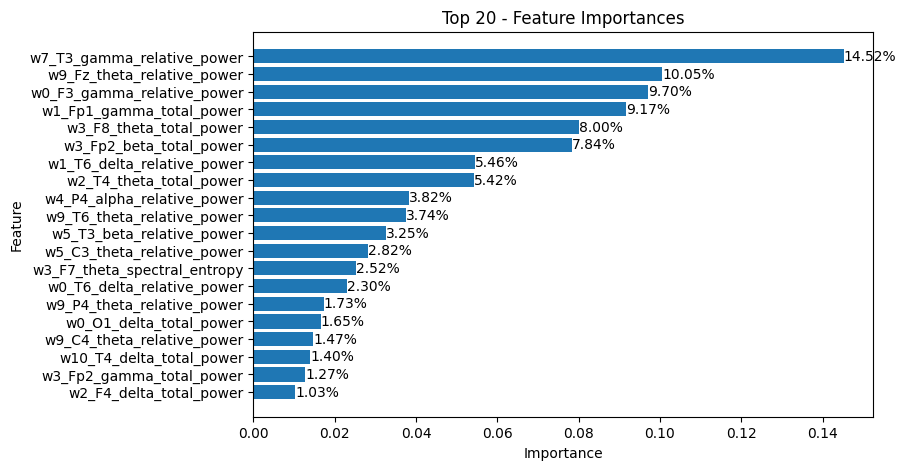

In [11]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_all.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

### StratifiedShuffleSplit (New Approach)

In [12]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print('Train:', X_train.shape[0])
print('Train:', X_test.shape[0])

Train: 35
Train: 9


#### Classifier - Default Parameters

In [13]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 88.89 %
F1 Score: 88.89 %
AUC: 90.0 %


In [14]:
best_clf = clf

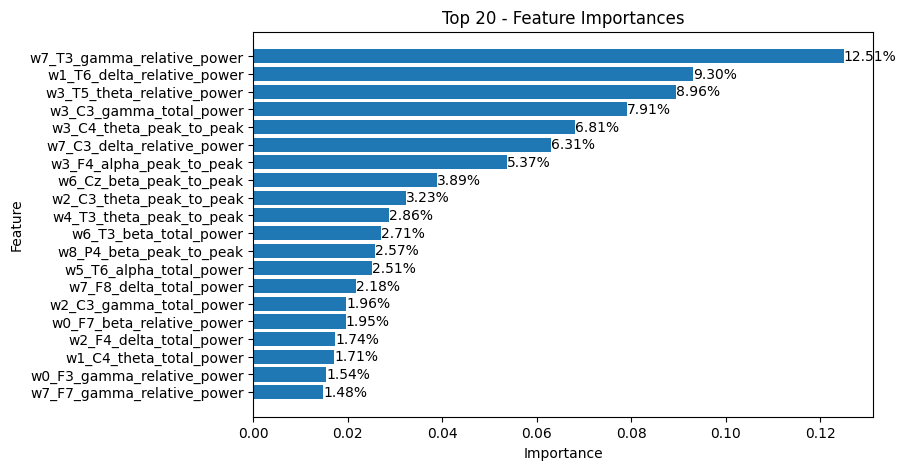

In [15]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_all.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

In [16]:
print('Number of Features used:', df_feat_importance[df_feat_importance['Importance']>0].shape[0])
df_feat_importance[df_feat_importance['Importance']>0]

Number of Features used: 37


,Feature,Importance
5370,w7_T3_gamma_relative_power,0.125057
243,w1_T6_delta_relative_power,0.093039
1534,w3_T5_theta_relative_power,0.089574
5077,w3_C3_gamma_total_power,0.079072
2361,w3_C4_theta_peak_to_peak,0.068147
346,w7_C3_delta_relative_power,0.063064
3613,w3_F4_alpha_peak_to_peak,0.053720
4938,w6_Cz_beta_peak_to_peak,0.038920
2341,w2_C3_theta_peak_to_peak,0.032265
2387,w4_T3_theta_peak_to_peak,0.028648


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      1.00      0.89         4

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9



#### SHAP

In [18]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(df_psd_features_all.drop(columns=cols_to_drop))
explanation = explainer(df_psd_features_all.drop(columns=cols_to_drop))

In [19]:
shap.force_plot(explainer.expected_value, shap_values[0, :], feature_names)

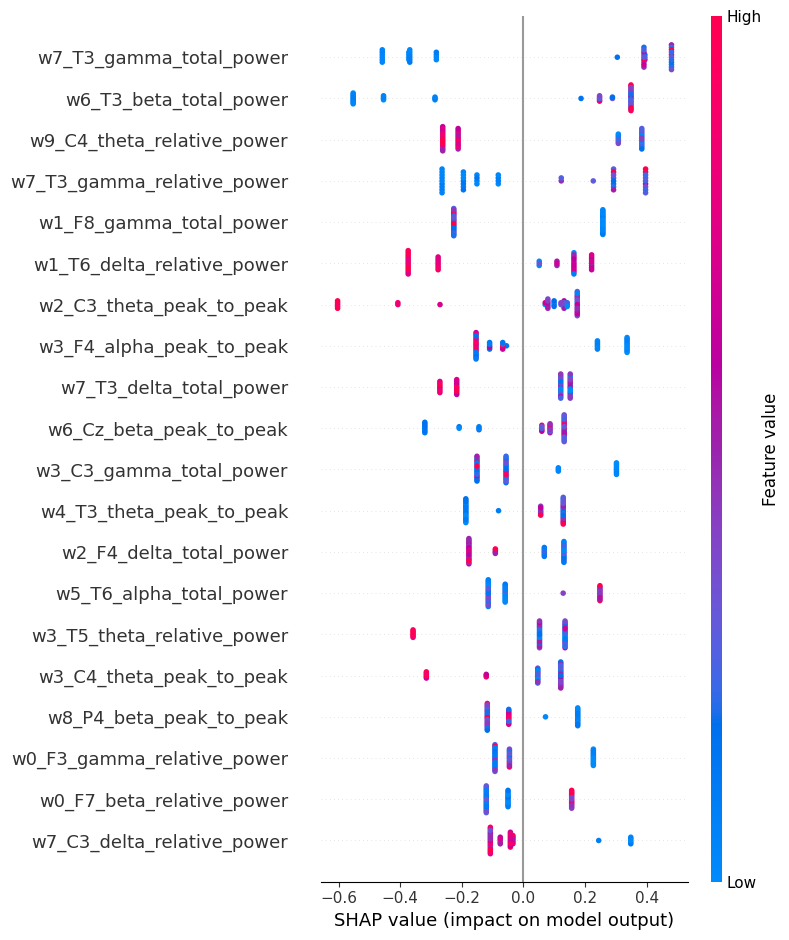

In [20]:
shap.summary_plot(shap_values, df_psd_features_all.drop(columns=cols_to_drop))

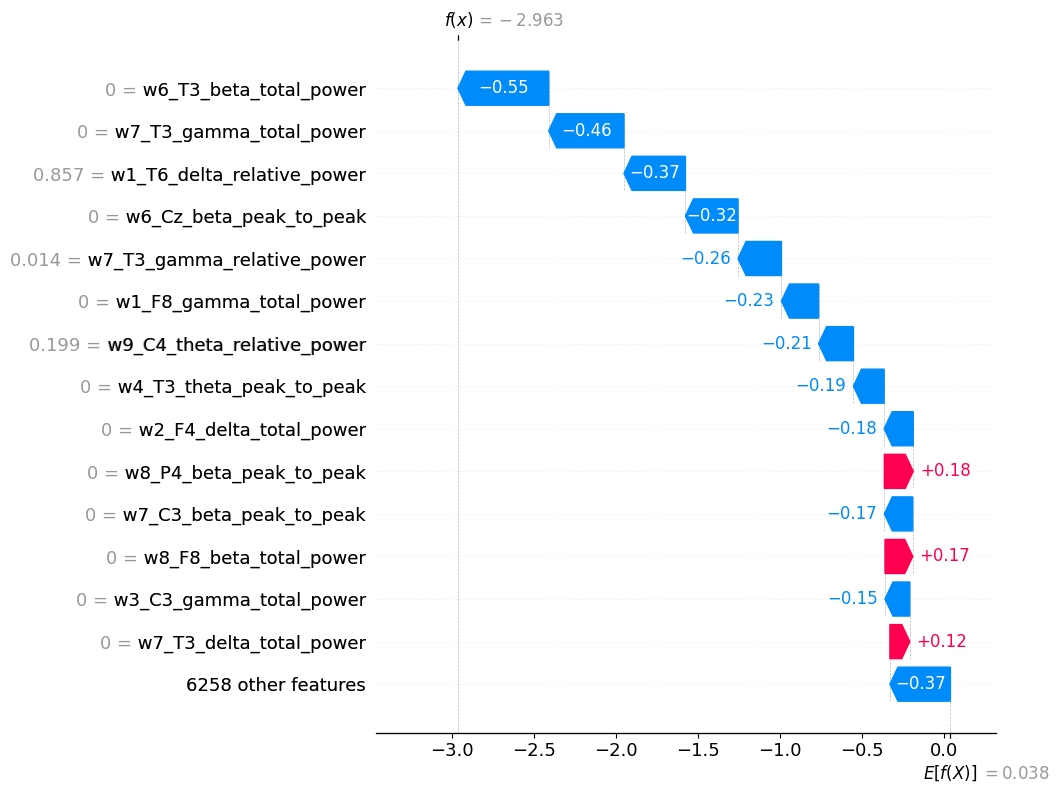

In [21]:
shap.plots.waterfall(explainer(df_psd_features_all.drop(columns=cols_to_drop))[0], max_display=15)

#### Hyperparameters Tunning

In [22]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
        'silent': 1,
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    y_pred = np.rint(preds)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-12-17 22:17:34,951] A new study created in memory with name: no-name-d89cd705-012d-4358-99f0-894c6423b540
[I 2023-12-17 22:17:35,051] Trial 0 finished with value: 0.4444444444444444 and parameters: {'booster': 'gbtree', 'lambda': 0.00013816752814058811, 'alpha': 0.003796481601417962, 'max_depth': 2, 'eta': 3.3384886912394054e-08, 'gamma': 0.008928879212075655, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4444444444444444.
[I 2023-12-17 22:17:35,059] Trial 1 finished with value: 0.7777777777777778 and parameters: {'booster': 'gblinear', 'lambda': 0.2430049033825247, 'alpha': 0.00029826288518519016}. Best is trial 1 with value: 0.7777777777777778.
[I 2023-12-17 22:17:35,067] Trial 2 finished with value: 0.4444444444444444 and parameters: {'booster': 'gblinear', 'lambda': 0.015530673319243403, 'alpha': 0.08979220521889694}. Best is trial 1 with value: 0.7777777777777778.
[I 2023-12-17 22:17:35,074] Trial 3 finished with value: 0.4444444444444444 and parameters: {'boo

Number of finished trials: 100
Best trial:
  Value: 0.7777777777777778
  Params: 
    booster: gblinear
    lambda: 0.2430049033825247
    alpha: 0.00029826288518519016


In [24]:
clf = xgb.XGBClassifier(**trial.params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Parameters Optimized'
list_scores.append(scores)

-- Scores: --
Accuracy: 77.78 %
F1 Score: 77.5 %
AUC: 77.5 %


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



#### Classifier - Using Feature Selection

In [26]:
selector = SelectKBest(score_func=chi2, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

clf = xgb.XGBClassifier()
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters - Feature Selection'
list_scores.append(scores)

-- Scores: --
Accuracy: 77.78 %
F1 Score: 77.5 %
AUC: 80.0 %


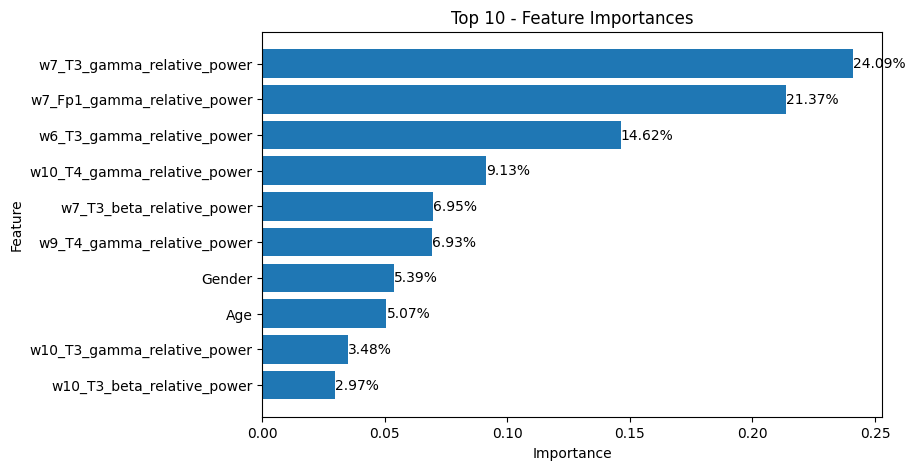

In [27]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(selector.get_feature_names_out(feature_names).tolist(),
                               clf.feature_importances_.tolist(),
                               top_n=10)

## FP1 Channel

In [28]:
X = df_psd_features_fp1.drop(columns=cols_to_drop).values
feature_names = df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list()
y = df_psd_features_fp1['Group'].values

### Train Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Classifier - Default Parameters

In [30]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Train Test Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 50.0 %
F1 Score: 49.74 %
AUC: 52.08 %


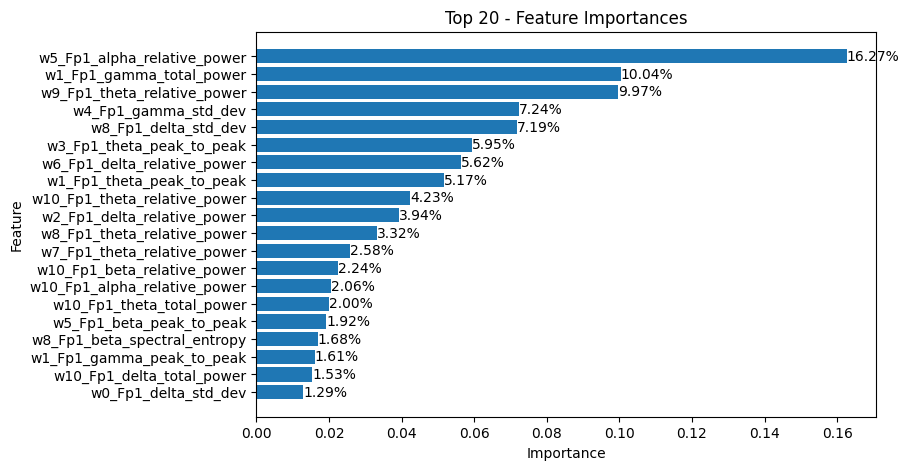

In [31]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

### StratifiedShuffleSplit (New Approach)

In [32]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.28, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Classifier - Default Parameters

In [33]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 69.23 %
F1 Score: 69.05 %
AUC: 69.05 %


In [34]:
best_clf = clf

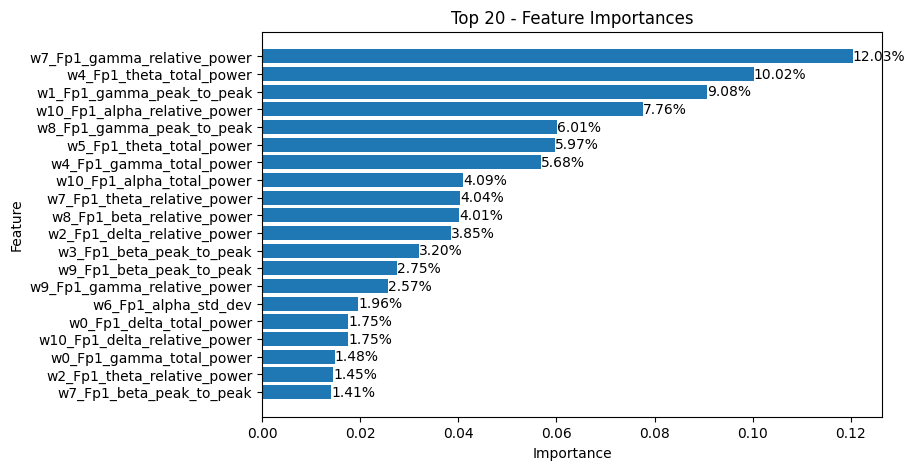

In [35]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

#### SHAP

In [36]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(df_psd_features_fp1.drop(columns=cols_to_drop))
explanation = explainer(df_psd_features_fp1.drop(columns=cols_to_drop))

In [37]:
shap.force_plot(explainer.expected_value, shap_values[0, :], feature_names)

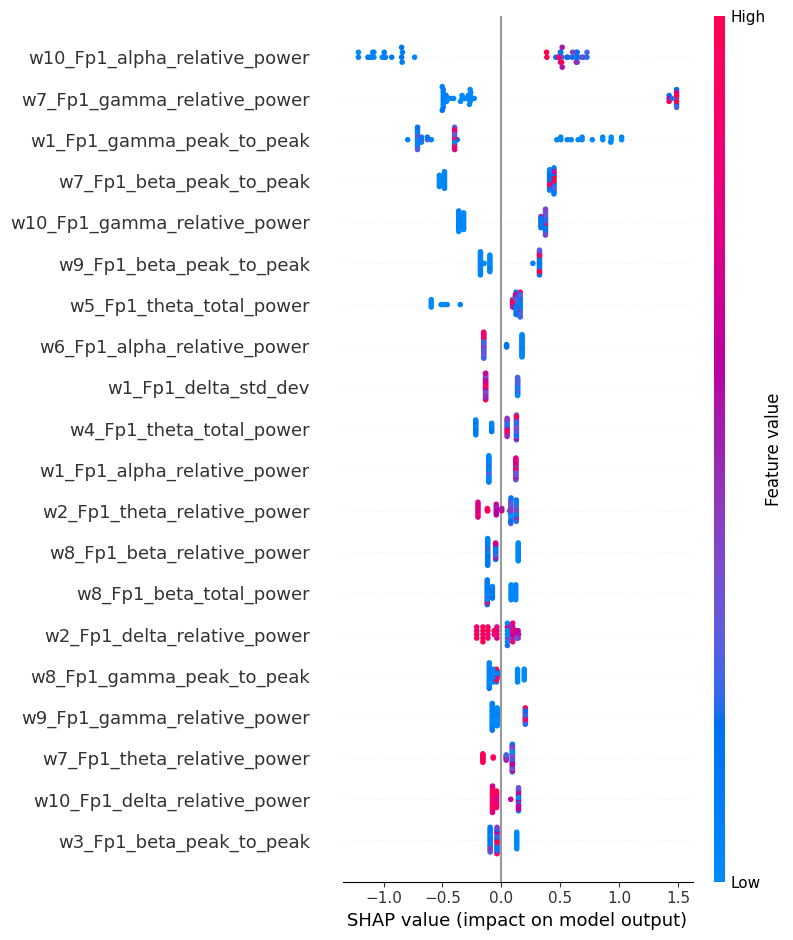

In [38]:
shap.summary_plot(shap_values, df_psd_features_fp1.drop(columns=cols_to_drop))

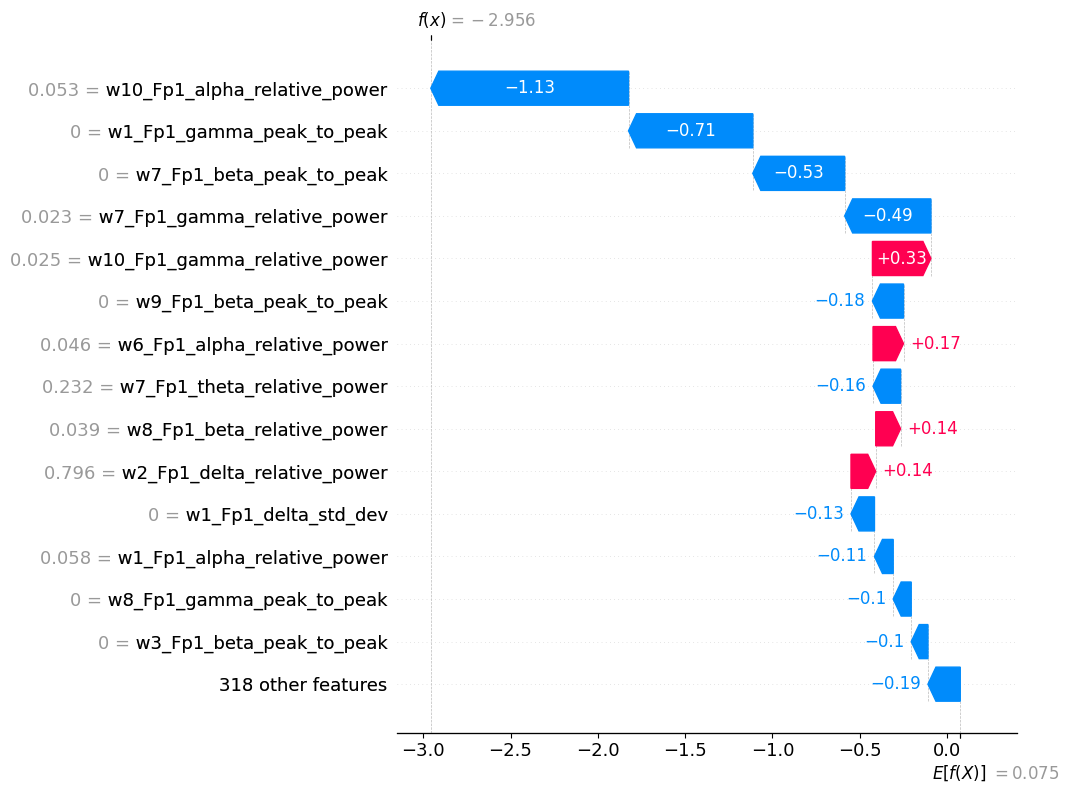

In [39]:
shap.plots.waterfall(explainer(df_psd_features_fp1.drop(columns=cols_to_drop))[0], max_display=15)

#### Hyperparameters Tunning

In [40]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-12-17 22:17:39,778] A new study created in memory with name: no-name-f5d0faa4-ab46-4b99-b49c-e79e01a45fe8
[I 2023-12-17 22:17:39,809] Trial 0 finished with value: 0.46153846153846156 and parameters: {'booster': 'dart', 'lambda': 0.0005140182443276701, 'alpha': 2.4773878048729843e-06, 'max_depth': 6, 'eta': 1.8167358719105548e-07, 'gamma': 4.702172080049483e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.12988435758250025, 'skip_drop': 0.0008404935726164534}. Best is trial 0 with value: 0.46153846153846156.
[I 2023-12-17 22:17:39,831] Trial 1 finished with value: 0.7692307692307693 and parameters: {'booster': 'gbtree', 'lambda': 0.0017347818442696302, 'alpha': 0.07005363543417358, 'max_depth': 9, 'eta': 0.029520096193421427, 'gamma': 2.553904085695442e-07, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7692307692307693.
[I 2023-12-17 22:17:39,836] Trial 2 finished with value: 0.6153846153846154 and parameters: {'b

Number of finished trials: 100
Best trial:
  Value: 0.8461538461538461
  Params: 
    booster: gbtree
    lambda: 0.00012621143524361626
    alpha: 0.002412212656590137
    max_depth: 3
    eta: 0.04353142404037619
    gamma: 1.3574611907417262e-07
    grow_policy: depthwise


In [41]:
clf = xgb.XGBClassifier(**trial.params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Parameters Optimized'
list_scores.append(scores)

-- Scores: --
Accuracy: 69.23 %
F1 Score: 69.05 %
AUC: 69.05 %


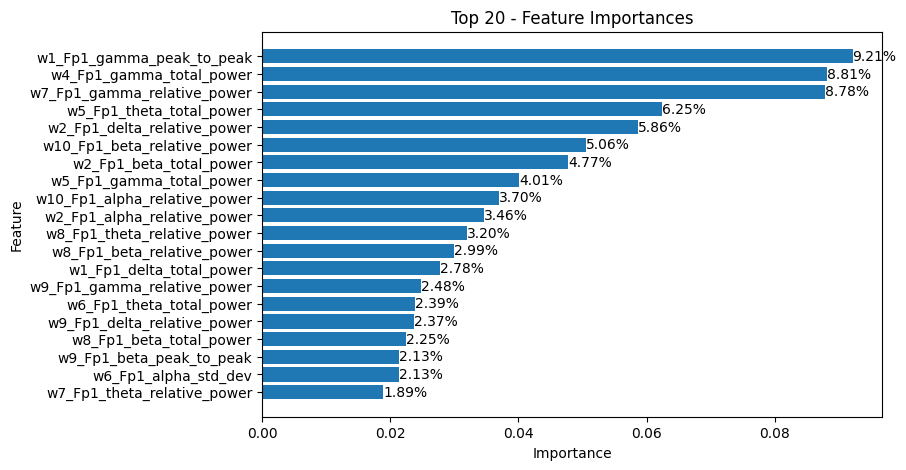

In [42]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

#### Classifier - Using Feature Selection

In [43]:
selector = SelectKBest(score_func=chi2, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

clf = xgb.XGBClassifier()
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters - Feature Selection'
list_scores.append(scores)

-- Scores: --
Accuracy: 61.54 %
F1 Score: 61.54 %
AUC: 61.9 %


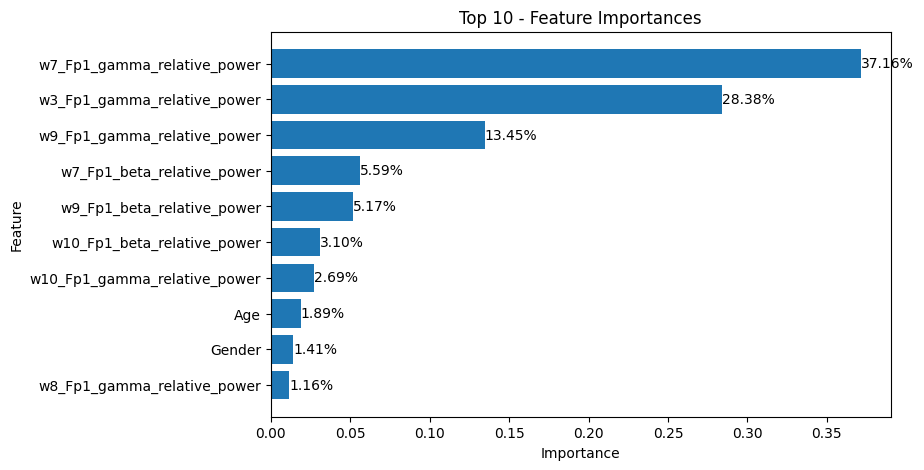

In [44]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(selector.get_feature_names_out(feature_names).tolist(),
                               clf.feature_importances_.tolist(),
                               top_n=10)

## Results

In [46]:
df_results = pd.DataFrame(list_scores)
df_results = df_results[['Approach', 'Channels', 'Accuracy', 'F1 Score', 'AUC']]
df_results

,Approach,Channels,Accuracy,F1 Score,AUC
0,Train Test Split - Default Parameters,All,0.444444,0.415584,0.416667
1,Stratified Shuffle Split - Default Parameters,All,0.888889,0.888889,0.900000
2,Stratified Shuffle Split - Parameters Optimized,All,0.777778,0.775000,0.775000
3,Stratified Shuffle Split - Default Parameters ...,All,0.777778,0.775000,0.800000
4,Train Test Split - Default Parameters,FP1,0.500000,0.497436,0.520833
5,Stratified Shuffle Split - Default Parameters,FP1,0.692308,0.690476,0.690476
6,Stratified Shuffle Split - Parameters Optimized,FP1,0.692308,0.690476,0.690476
7,Stratified Shuffle Split - Default Parameters ...,FP1,0.615385,0.615385,0.619048
